# 安徽安庆市项目`WRF-CMAQ`模拟分析
## Model Evaluation : `chem-obs data`

---
*@author: Evan*\
*@date: 2023-06-21*

In [1]:
import sys
sys.path.append('../../../src/')
import ModelEvaLib as me
# from namelist import *

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry as sgeom
from shapely.prepared import prep

import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
        "font.family":'Times New Roman',
        "mathtext.fontset":'stix',
        "font.serif": ['Times New Roman'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
def polygon_to_mask(polygon, x, y):
    '''
    Generate a mask array of points falling into the polygon
    '''
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    mask = np.zeros(x.shape, dtype=bool)

    # if each point falls into a polygon, without boundaries
    prepared = prep(polygon)
    for index in np.ndindex(x.shape):
        point = sgeom.Point(x[index], y[index])
        if prepared.contains(point):
            mask[index] = True

    return mask

## 杭州市

In [4]:
meic = xr.open_dataset('F:/Data/Project_Xiaoshan/compare_emis/XS_meic.nc')
heic = xr.open_dataset('F:/Data/Project_Xiaoshan/compare_emis/XS_heic.nc')

O3_meic = meic.O3[:,0,:,:]
O3_heic = heic.O3[:,0,:,:]

In [5]:
O3_meic

<xarray.DataArray 'O3' (time: 144, y: 138, x: 135)>
[2682720 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2022-09-02 ... 2022-09-07T23:00:00
    level      float64 1e+03
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Attributes:
    long name:  Ozone
    units:      ug m-3

In [6]:
lon = meic.longitude
lat = heic.latitude
shp = gpd.read_file('F:/Data/Project_Xiaoshan/shapefile/杭州市/杭州市.shp')

mask    = polygon_to_mask(shp.geometry[0],lon,lat)
mask_da = xr.DataArray(mask,dims=('y','x'))

mask_O3_meic = O3_meic.where(mask_da)
O3_meic_mean = mask_O3_meic.mean(dim=['y','x'],skipna=True)

mask_O3_heic = O3_heic.where(mask_da)
O3_heic_mean = mask_O3_heic.mean(dim=['y','x'],skipna=True)

In [23]:
obsxls = pd.read_excel('F:/Data/Project_Xiaoshan/202209/obsdata/hz_202209.xlsx',index_col=0)
groups = obsxls.groupby('Station')
o3 = {}

for gp in groups:
    station = gp[0]
    o3[station] = gp[1]['O3']

df = pd.concat(o3,axis=1)
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
datetime,,,,,,,,,,,,,,
2022-09-01 00:00:00,70.0,63.0,NaN,73.0,69.0,74.0,NaN,72.0,85.0,72.0,64.0,74.0,77.0,69.0
2022-09-01 01:00:00,82.0,64.0,NaN,70.0,68.0,70.0,NaN,73.0,82.0,82.0,64.0,69.0,78.0,78.0
2022-09-01 02:00:00,79.0,65.0,NaN,69.0,70.0,65.0,NaN,68.0,74.0,78.0,60.0,62.0,76.0,70.0
2022-09-01 03:00:00,70.0,59.0,NaN,58.0,66.0,62.0,NaN,55.0,60.0,70.0,57.0,65.0,73.0,69.0
2022-09-01 04:00:00,61.0,52.0,NaN,51.0,59.0,56.0,NaN,57.0,50.0,61.0,56.0,68.0,59.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 19:00:00,134.0,125.0,NaN,117.0,148.0,146.0,NaN,123.0,124.0,127.0,161.0,183.0,224.0,126.0
2022-09-30 20:00:00,111.0,104.0,NaN,86.0,125.0,113.0,NaN,109.0,100.0,93.0,137.0,138.0,151.0,103.0
2022-09-30 21:00:00,82.0,72.0,NaN,69.0,88.0,80.0,NaN,79.0,76.0,63.0,111.0,128.0,123.0,68.0


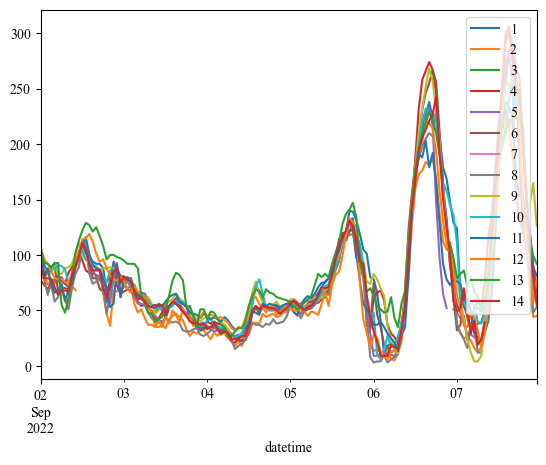

In [28]:
df.loc['2022-09-02':'2022-09-07'].plot()
plt.show()

In [16]:
obs = df.loc['2022-09-02':'2022-09-07'].mean(axis=1)
obs

datetime
2022-09-02 00:00:00     93.750000
2022-09-02 01:00:00     83.750000
2022-09-02 02:00:00     81.750000
2022-09-02 03:00:00     81.500000
2022-09-02 04:00:00     79.750000
                          ...    
2022-09-07 19:00:00    171.666667
2022-09-07 20:00:00    134.250000
2022-09-07 21:00:00    102.500000
2022-09-07 22:00:00     78.000000
2022-09-07 23:00:00     71.750000
Length: 144, dtype: float64

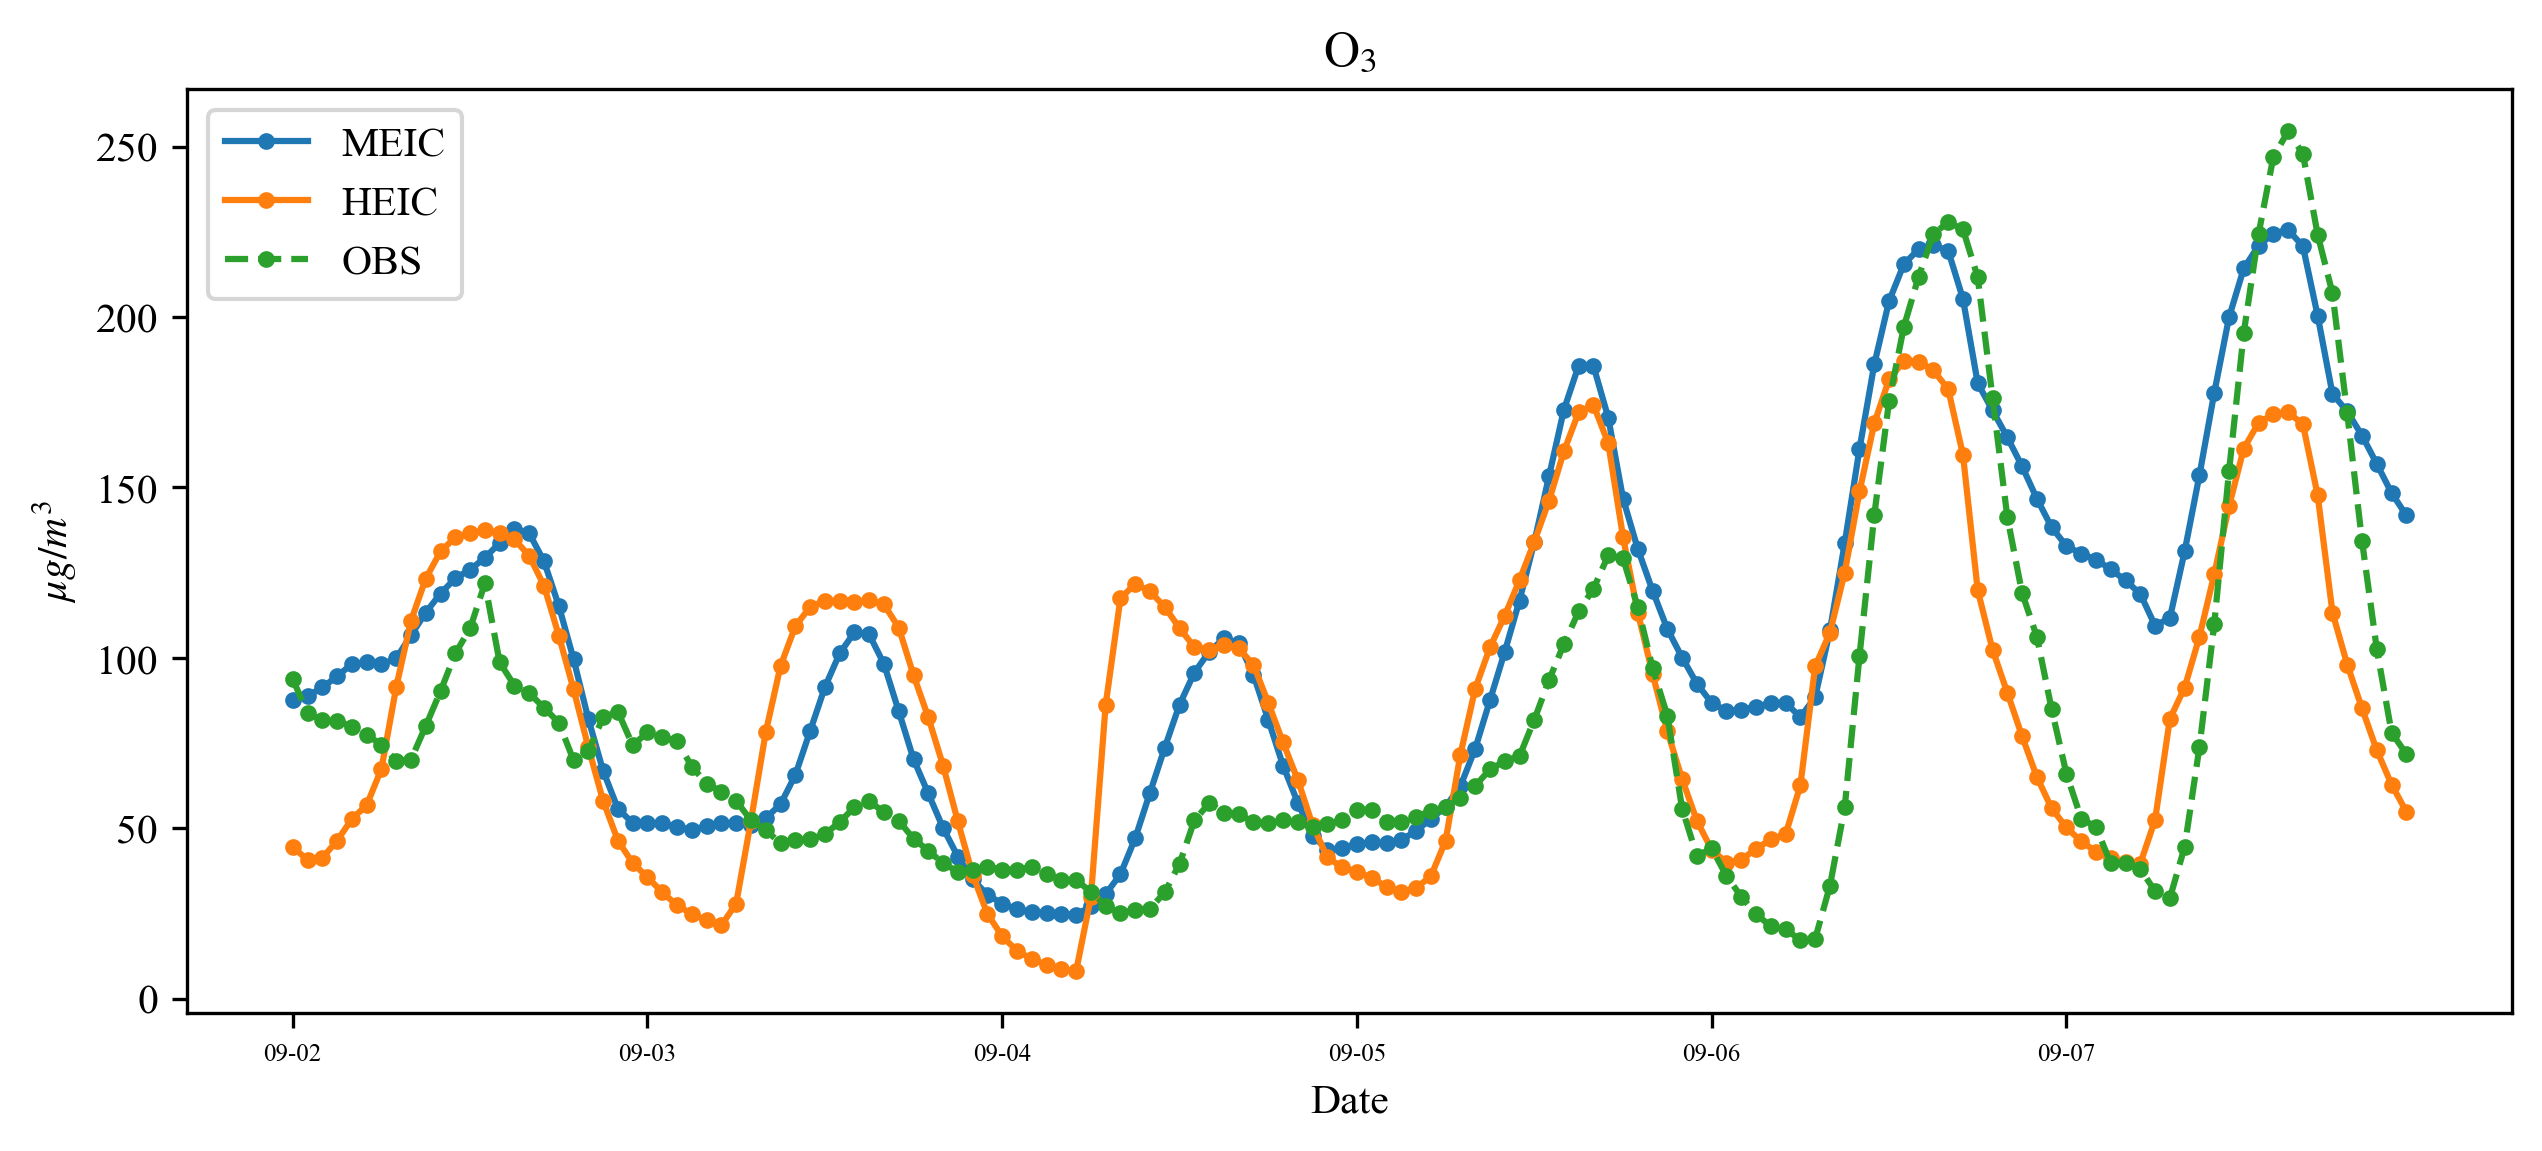

In [26]:
start_date='2022-09-02T00'
end_date='2022-09-07T23'

timelength=np.size(pd.date_range(start_date,end_date,freq='h'))
date = pd.date_range(start_date,end_date,freq='D')
time = np.arange(0,timelength)

fig = plt.figure(figsize=(10,4),dpi=300)
ax = fig.subplots()
ax.plot(time,O3_meic_mean,label='MEIC',marker='.')
ax.plot(time,O3_heic_mean,label='HEIC',marker='.')
ax.plot(time,obs,label='OBS',marker='.',linestyle='--')
ax.set_xticks(np.arange(0,timelength,24))
ax.set_xticklabels(date.strftime('%m-%d'),size=6)

ax.legend(loc=2)
ax.set_title('O$_3$')
ax.set_xlabel('Date')
ax.set_ylabel('$\mu$$g/m^3$')
plt.show()

In [20]:
sim = O3_meic_mean
df = pd.DataFrame({'sim':sim, 'obs':obs})
me.evaluation_frame(obs, sim, df)

,param,value
0,obs mean,81.539478
1,sim mean,106.215965
2,R,0.833069
3,MB,24.676487
4,RMSE,<xarray.DataArray ()>\narray(39.96671711)\nCoo...
5,IOA,<xarray.DataArray ()>\narray(0.86923676)\nCoor...


In [21]:
sim = O3_heic_mean
df = pd.DataFrame({'sim':sim, 'obs':obs})
me.evaluation_frame(obs, sim, df)

,param,value
0,obs mean,81.539478
1,sim mean,87.649002
2,R,0.655371
3,MB,6.109524
4,RMSE,<xarray.DataArray ()>\narray(43.40287546)\nCoo...
5,IOA,<xarray.DataArray ()>\narray(0.80085329)\nCoor...
